[reference](https://github.com/bentrevett/pytorch-sentiment-analysis)

In [0]:
# Importing Libraries
import os
import copy
import time
import torch
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/lt-module'
os.chdir(path)

In [0]:
# Custom Libraries
import DataLoader
import Model

## Define functions - to load dataset & model

In [0]:
# load dataset
def load_dataset(dataset, architecture, batch_size, device, path):
    if dataset == "imdb":
      if architecture == "cnn":
        data = DataLoader.IMDB_CNN(batch_size, device, path)
      elif architecture == "lstm":
        data = DataLoader.IMDB_LSTM(batch_size, device, path)

    elif dataset == "agnews":
        data = DataLoader.AGNEWS(batch_size, device, path)

    else:
        raise ValueError(dataset + "is not supported")

    return data

# load model and set hyperparameters
def load_model(architecture, data_choice, batch_size):

    if architecture == "cnn":
      # hyperparameters
      vocab_size = len(dataset.TEXT.vocab)
      embedding_dim = 100
      n_filters = 100
      filter_sizes = [3,4,5]
      dropout = 0.5
      pad_idx = dataset.TEXT.vocab.stoi[dataset.TEXT.pad_token]
      
      if data_choice == "imdb":
        # binary-class
        output_dim = 1
        model = Model.binaryCNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)
      
      elif data_choice == "agnews":
        # multi-class
        output_dim = 4
        model = Model.multiCNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

      unk_idx = dataset.TEXT.vocab.stoi[dataset.TEXT.unk_token]
      model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
      model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

      return model

    elif architecture == "lstm":
      # hyperparameters
      vocab_size = len(dataset.TEXT.vocab)
      embedding_dim = 100
      hidden_dim = 256
      output_dim = 1
      n_layers = 2
      bidirectional = True
      dropout = 0.5
      pad_idx = dataset.TEXT.vocab.stoi[dataset.TEXT.pad_token]
      
      if data_choice == "imdb":
        # binary-class
        output_dim = 1
      
      elif data_choice == "agnews":
        # multi-class
        output_dim = 4
      
      model = Model.LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx)

      unk_idx = dataset.TEXT.vocab.stoi[dataset.TEXT.unk_token]
      model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
      model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

      return model

    # temporary
    elif architecture == "bert":
        return None

    else:
        raise ValueError(architecture + "is not supported")

## Choose dataset & model

In [0]:
# colab에서 돌리기 때문에 우선 arg가 아니라 변수로 넘겨주기
data_choice = "imdb" # 데이터셋 선택
arch_choice = "cnn" # 모델 선택
batch_size = 64 # batch size 선택 - 32 or 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device.')

Using cuda device.


In [0]:
# load dataset
dataset = load_dataset(data_choice, arch_choice, batch_size, device, path)

#### CNN

In [0]:
# load model and set hyperparameters
model = load_model(arch_choice, data_choice, batch_size)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,620,801 trainable parameters


## Weight initialization

In [0]:
# weight initializtion
def initialize_xavier_normal(m):
    
  """
	Function to initialize a layer by picking weights from a xavier normal distribution
	Arguments
	---------
	m : The layer of the neural network
	Returns
	-------
	None
	"""
  
  if type(m) == torch.nn.Conv2d:
    torch.nn.init.xavier_normal_(m.weight)
    m.bias.data.fill_(0)

  elif type(m) in [torch.nn.GRU, torch.nn.LSTM, torch.nn.RNN]:
    for name, param in m.named_parameters():
        if 'weight_ih' in name:
          torch.nn.init.xavier_normal_(param.data)
        elif 'weight_hh' in name:
          torch.nn.init.orthogonal_(param.data)
        elif 'bias' in name:
          param.data.fill_(0)

In [0]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

## train and test functions

In [0]:
def train(model, iterator, optimizer, criterion):
    # EPS = 1e-6
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
      
      text = batch.text[0]
      target = batch.label
        
      optimizer.zero_grad()
      predictions = model(text).squeeze(1)
      loss = criterion(predictions, target)
      acc = binary_accuracy(predictions, target)
      loss.backward()
      step = 0

      # Freezing Pruned weights by making their gradients Zero
      for name, p in model.named_parameters():
        weight_dev = param.device
        tensor = p.data.cpu().numpy()
        grad_tensor = p.grad.data.cpu().numpy()
        grad_tensor = np.where(mask[step] == 0, 0, grad_tensor)
        p.grad.data = torch.from_numpy(grad_tensor).to(device)
        step += 1
      
      step = 0

      optimizer.step()
        
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
          text = batch.text[0]
          target = batch.label

          predictions = model(batch.text[0]).squeeze(1)
            
          loss = criterion(predictions, batch.label)
            
          acc = binary_accuracy(predictions, batch.label)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Pruning Functions

In [0]:
# Prune by Percentile module
def prune_by_percentile(percent):
  global step
  global mask
  global model
  # Calculate percentile value
  step = 0
  for name, param in model.named_parameters():
    # if 'weight' in name:
    tensor = param.data.cpu().numpy()
    nz_count = np.count_nonzero(tensor)

    # bias가 all pruned 되는 경우 발생
    if nz_count == 0:
      step += 1

    else: 
      alive = tensor[np.nonzero(tensor)] # flattened array of nonzero values
      percentile_value = np.percentile(abs(alive), percent)

      # Convert Tensors to numpy and calculate
      weight_dev = param.device
      new_mask = np.where(abs(tensor) < percentile_value, 0, mask[step])
                
      # Apply new weight and mask
      param.data = torch.from_numpy(tensor * new_mask).to(weight_dev)
      mask[step] = new_mask
      step += 1

  step = 0

In [0]:
# Function to make an empty mask of the same size as the model
def make_mask(model):
  global step
  global mask
  
  step = 0
  for name, param in model.named_parameters(): 
    # if 'weight' in name:
    step += 1
  mask = [None]* step 
  step = 0
  for name, param in model.named_parameters(): 
    # if 'weight' in name:
    tensor = param.data.cpu().numpy()
    mask[step] = np.ones_like(tensor)
    step += 1
  step = 0

In [0]:
def original_initialization(mask_temp, initial_state_dict):
    global step
    global model
    
    step = 0
    for name, param in model.named_parameters(): 
        # if "weight" in name: 
            weight_dev = param.device
            param.data = torch.from_numpy(mask_temp[step] * initial_state_dict[name].cpu().numpy()).to(weight_dev)
            step = step + 1
        # if "bias" in name:
            # param.data = initial_state_dict[name]
    step = 0

In [0]:
# ANCHOR Print table of zeros and non-zeros count
def print_nonzeros(model):
    nonzero = total = 0
    for name, p in model.named_parameters():
        tensor = p.data.cpu().numpy()
        nz_count = np.count_nonzero(tensor)
        total_params = np.prod(tensor.shape)
        nonzero += nz_count
        total += total_params
        print(f'{name:20} | nonzeros = {nz_count:7} / {total_params:7} ({100 * nz_count / total_params:6.2f}%) | total_pruned = {total_params - nz_count :7} | shape = {tensor.shape}')
    print(f'alive: {nonzero}, pruned : {total - nonzero}, total: {total}, Compression rate : {total/nonzero:10.2f}x  ({100 * (total-nonzero) / total:6.2f}% pruned)')
    return (round(((total-nonzero)/total)*100,1))

## 실제로 해보기

In [0]:
reinit = True # random이면 True, lt면 False

if reinit == True:
  mode = "random"
else:
  mode = "lt"

In [0]:
# model initialization and save the model
model.apply(initialize_xavier_normal)

initial_state_dict = copy.deepcopy(model.state_dict())

# model.state_dict()로 저장하면 state만 저장
torch.save(model, f"{path}/{data_choice}-{arch_choice}-initial_state_dict-{mode}.pt")

In [0]:
model = model.to(device)

In [0]:
make_mask(model)

In [0]:
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

criterion = criterion.to(device)

In [0]:
for name, param in model.named_parameters():
  print(name, param.size())

embedding.weight torch.Size([25002, 100])
convs.0.weight torch.Size([100, 1, 3, 100])
convs.0.bias torch.Size([100])
convs.1.weight torch.Size([100, 1, 4, 100])
convs.1.bias torch.Size([100])
convs.2.weight torch.Size([100, 1, 5, 100])
convs.2.bias torch.Size([100])
fc.weight torch.Size([1, 300])
fc.bias torch.Size([1])


In [0]:
# Pruning
iteration = 20
percent = 20 # 20% prune
N_EPOCH = 10
step = 0

### random

In [72]:
print("Iterative Pruning started")

frac = [] # Pruned percentage를 담을 리스트
performance = [] # 결과값을 담을 리스트


for pruning_iter in range(0,iteration+1):
  print(f"Running pruning iteration {pruning_iter}/{iteration}")

  # 첫 iter에는 no model compression
  if not pruning_iter == 0:

    # pruning
    prune_by_percentile(percent)

    # random initialization
    if reinit:
      model.apply(initialize_xavier_normal)
      step = 0
      for name, param in model.named_parameters():
      # if 'weight' in name: 
         weight_dev = param.device
         param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
         step = step + 1
      step = 0
    
    # lt initialization
    else:
      original_initialization(mask, initial_state_dict)

    optimizer = optim.Adam(model.parameters())

  # train 
  best_train_loss = float('inf')
  best_train_acc = float('inf')
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model, dataset.train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, dataset.valid_iter, criterion)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'temp.pt')

  # test
  model.load_state_dict(torch.load('temp.pt'))
  test_loss, test_acc = evaluate(model, dataset.test_iter, criterion)

  performance.append(100*test_acc)

  per = print_nonzeros(model)
  frac.append(per)

Iterative Pruning started
Running pruning iteration 0/20
embedding.weight     | nonzeros = 2500100 / 2500200 (100.00%) | total_pruned =     100 | shape = (25002, 100)
convs.0.weight       | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 1, 3, 100)
convs.0.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
convs.1.weight       | nonzeros =   40000 /   40000 (100.00%) | total_pruned =       0 | shape = (100, 1, 4, 100)
convs.1.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
convs.2.weight       | nonzeros =   50000 /   50000 (100.00%) | total_pruned =       0 | shape = (100, 1, 5, 100)
convs.2.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc.weight            | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (1, 300)
fc.bias              | nonzeros =       1 /       1 (100.00%) | total_pru

### lt

In [0]:
print("Iterative Pruning started")

frac = [] # Pruned percentage를 담을 리스트
performance = [] # 결과값을 담을 리스트


for pruning_iter in range(0,iteration+1):
  print(f"Running pruning iteration {pruning_iter}/{iteration}")

  # 첫 iter에는 no model compression
  if not pruning_iter == 0:

    # pruning
    prune_by_percentile(percent)

    # random initialization
    if reinit:
      model.apply(initialize_xavier_normal)
      step = 0
      for name, param in model.named_parameters():
      # if 'weight' in name: 
         weight_dev = param.device
         param.data = torch.from_numpy(param.data.cpu().numpy() * mask[step]).to(weight_dev)
         step = step + 1
      step = 0
    
    # lt initialization
    else:
      original_initialization(mask, initial_state_dict)

    optimizer = optim.Adam(model.parameters())

  # train 
  best_train_loss = float('inf')
  best_train_acc = float('inf')
  best_valid_loss = float('inf')

  for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model, dataset.train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, dataset.valid_iter, criterion)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'temp.pt')

  # test
  model.load_state_dict(torch.load('temp.pt'))
  test_loss, test_acc = evaluate(model, dataset.test_iter, criterion)

  performance.append(100*test_acc)

  per = print_nonzeros(model)
  frac.append(per)

Iterative Pruning started
Running pruning iteration 0/20
embedding.weight     | nonzeros = 2500100 / 2500200 (100.00%) | total_pruned =     100 | shape = (25002, 100)
convs.0.weight       | nonzeros =   30000 /   30000 (100.00%) | total_pruned =       0 | shape = (100, 1, 3, 100)
convs.0.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
convs.1.weight       | nonzeros =   40000 /   40000 (100.00%) | total_pruned =       0 | shape = (100, 1, 4, 100)
convs.1.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
convs.2.weight       | nonzeros =   50000 /   50000 (100.00%) | total_pruned =       0 | shape = (100, 1, 5, 100)
convs.2.bias         | nonzeros =     100 /     100 (100.00%) | total_pruned =       0 | shape = (100,)
fc.weight            | nonzeros =     300 /     300 (100.00%) | total_pruned =       0 | shape = (1, 300)
fc.bias              | nonzeros =       1 /       1 (100.00%) | total_pru

In [73]:
# random
print(performance)

[88.2265127388535, 88.16679936305732, 88.40565286624204, 88.02746815286623, 88.05732484076432, 87.75875796178345, 87.86823248407643, 87.83837579617835, 87.35071656050955, 87.03224522292994, 86.5545382165605, 86.36544585987261, 86.46496815286623, 85.95740445859873, 85.85788216560509, 85.1015127388535, 85.49960191082803, 84.35509554140127, 83.92714968152866, 83.25039808917197, 80.1453025477707]


In [0]:
# lt
print(performance)

[89.3312101910828, 88.81369426751591, 88.21656050955414, 87.8781847133758, 87.38057324840764, 87.11186305732484, 86.57444267515923, 86.73367834394905, 86.83320063694268, 86.5545382165605, 86.2062101910828, 85.25079617834395, 85.11146496815286, 84.82285031847134, 83.49920382165605, 82.04617834394905, 82.17555732484077, 81.08081210191082, 80.4140127388535, 79.19984076433121, 74.81090764331209]


In [0]:
lt_performance = [89.3312101910828, 88.81369426751591, 88.21656050955414, 87.8781847133758, 87.38057324840764, 87.11186305732484, 86.57444267515923, 86.73367834394905, 86.83320063694268, 86.5545382165605, 86.2062101910828, 85.25079617834395, 85.11146496815286, 84.82285031847134, 83.49920382165605, 82.04617834394905, 82.17555732484077, 81.08081210191082, 80.4140127388535, 79.19984076433121, 74.81090764331209]

In [0]:
if reinit == True:
  reinit_performance = performance
else:
  lt_performance = performance

# Plot

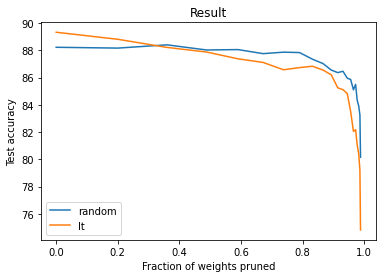

In [76]:
from matplotlib import pyplot as plt

frac = [0,0.2,0.36,0.488,0.59,0.672,0.738,0.79,0.832,0.866,0.893,0.914,0.931,0.945,0.956,0.965,0.972,0.977,0.982,0.986,0.988]

plt.plot(frac, reinit_performance)
plt.plot(frac, lt_performance)
plt.xlabel('Fraction of weights pruned')
plt.ylabel('Test accuracy')
plt.legend(['random', 'lt'])
plt.title(f'Result')

plt.show()